In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
day_cases_by_country = pd.read_csv("daily-cases-by-country.csv")
country_income_groups = pd.read_csv("country_income_groups.csv")

The cell below:
- Makes the UK and USA string identificators to be the same in the income dataset and the cases dataset.
- Adds an income column obtained from the income dataset to the cases dataset (and removes countries that are not in the income dataset).
- Removes NA values and not necessary columns from the cases dataset.
- The output is a df named "cases_dataset".

In [3]:
# Replace the UK and USA names of the income dataframe to the same string in the cases dataframe.
country_income_groups["TableName"] = country_income_groups["TableName"].replace({'United States':'United_States_of_America','United Kingdom':'United_Kingdom'})

# Get the unique territories from the cases dataset and the income dataset.
casescountries = day_cases_by_country["countriesAndTerritories"].unique()
incomecountries = country_income_groups["TableName"]

# Get the elements that are in both lists only.
countries = set(casescountries).intersection(incomecountries)

# Subset both dataframes with the countries list.
cases_dataset = day_cases_by_country[day_cases_by_country["countriesAndTerritories"].isin(countries)]
income_dataset = country_income_groups[country_income_groups["TableName"].isin(countries)]

# Make a dictionary with the countries and the income groups.
income_dict = dict(zip(income_dataset["TableName"], country_income_groups["IncomeGroup"]))

# Append to a new list the income of each country.
incometags = []
allcountries = cases_dataset["countriesAndTerritories"]
for i in allcountries:
    incometags.append(income_dict[i])

# Add a new column to the cases dataframe with the income of the countries.
cases_dataset["Incomes"] = incometags

# Remove unnecesary columns and na.
cases_dataset = cases_dataset.drop(columns = ["geoId", "year"])
cases_dataset = cases_dataset.dropna()

#cases_dataset

/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The cell below:
- Creates a function that makes a range of dates given a start date and an end date (both must be in [dd,mm,yy] format.
- Adds a day count column to the cases df, whose day 1 is the earliest date recorded and last day is the latest date recorded.
- Sorts the cases df by the day counts.
- The output is a df called "sorted_dataset"

In [4]:
# Make a function to get a date range. The inputs should be two list with [dd,mm,yy] structure.
def get_date_range(startdate, enddate):
    
    # Import module:
    from datetime import timedelta, date
    def daterange(date1, date2):
        for n in range(int ((date2 - date1).days)+1):
            yield date1 + timedelta(n)
    
    datesrange = []
    start_dt = date(startdate[2], startdate[1], startdate[0])
    end_dt = date(enddate[2], enddate[1], enddate[0])
    for dt in daterange(start_dt, end_dt):
        datesrange.append(dt.strftime(("%d/%m/%Y")))
    
    return(datesrange)

# Get range of dates from the first(13 jan 2020) to the last(17 oct 2020) day of count.
datesrange = get_date_range([13,1,2020], [17,10,2020])

# Get the day count for each date on the range.
datescount = []
count = 1
for i in datesrange:
    datescount.append(count)
    count = count + 1

# Make a dictionary with each date and the day count.
dates_dict = dict(zip(datesrange, datescount))

# Get all the dates on the cases dataset.
datesdataset = cases_dataset["dateRep"]

# Create a list to store the day count of each date on the dataset.
daycounts = []
for i in cases_dataset["dateRep"]:
    daycounts.append(dates_dict[i])

# Add a new column with the day counts.
cases_dataset["DayCounts"] = daycounts

# Sort the dataset by the daycount.
sorted_dataset = cases_dataset.sort_values(by = ["DayCounts"])

# Remake the indices.
sorted_dataset.reset_index(drop=True, inplace=True)
#sorted_dataset

The cell below:
- Creates a dictionary with all the countries as keys and a list with two elements as values to store the cumulative cases and deaths for each country and each day. (e.g. { "Spain" : [0,0], "Ireland" : [0,0] }
- Uses the dictionary to fill empty lists with the cumulative cases and deaths for each day and each country.
- Adds four columns to the "sorted_dataset", two being the cumulative cases and the cumulative deaths, and the other two being the normalized version of the first two.

In [5]:
# Create a dictionary to store the cumulative cases and deaths for each country.
uniquecountries = sorted_dataset["countriesAndTerritories"].unique()
cases_deaths_dict = {}
for i in range(len(uniquecountries)):
    cases_deaths_dict[uniquecountries[i]] = [0,0]
    
# Create empty lists to store each cumulative data, and normalized data.
cumulative_cases = []
cumulative_deaths = []
cases_norm = []
deaths_norm = []

# Loop through the dataset rows.
for i in range(len(sorted_dataset)):
    
    # Get current row country, cases, deaths and pupulation.
    cases = sorted_dataset.iloc[i,3]
    deaths = sorted_dataset.iloc[i,4]
    country = sorted_dataset.iloc[i,5]
    population = sorted_dataset.iloc[i,7]
    
    # Update the dictionary with the new cases and deaths.
    cases_deaths_dict[country] = [cases_deaths_dict[country][0] + cases, cases_deaths_dict[country][1] + deaths]
    
    # Append the cumulative lists.
    cumulative_cases.append(cases_deaths_dict[country][0])
    cumulative_deaths.append(cases_deaths_dict[country][1])
    cases_norm.append(cases_deaths_dict[country][0] * 100000/ population)
    deaths_norm.append(cases_deaths_dict[country][1] * 100000/ population)
    
sorted_dataset["CumulativeCases"] = cumulative_cases
sorted_dataset["CumulativeDeaths"] = cumulative_deaths
sorted_dataset["CasesNorm"] = cases_norm
sorted_dataset["DeathsNorm"] = deaths_norm
sorted_dataset

,dateRep,day,month,cases,deaths,countriesAndTerritories,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,Incomes,DayCounts,CumulativeCases,CumulativeDeaths,CasesNorm,DeathsNorm
0,13/01/2020,13,1,0,0,Austria,AUT,8858775.0,Europe,0.000000,Upper middle income,1,0,0,0.000000,0.000000
1,13/01/2020,13,1,0,0,Georgia,GEO,3996762.0,Europe,0.000000,High income,1,0,0,0.000000,0.000000
2,13/01/2020,13,1,0,0,Canada,CAN,37411038.0,America,0.000000,Upper middle income,1,0,0,0.000000,0.000000
3,13/01/2020,13,1,0,0,Monaco,MCO,33085.0,Europe,0.000000,Upper middle income,1,0,0,0.000000,0.000000
4,13/01/2020,13,1,0,0,Azerbaijan,AZE,10047719.0,Europe,0.000000,Upper middle income,1,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27292,17/10/2020,17,10,998,14,Bulgaria,BGR,7000039.0,Europe,102.413715,Low income,279,28342,955,404.883459,13.642781
27293,17/10/2020,17,10,886,16,Paraguay,PRY,7044639.0,America,153.279678,Upper middle income,279,53455,1165,758.803964,16.537398
27294,17/10/2020,17,10,7705,132,Poland,POL,37972812.0,Europe,162.840192,High income,279,157370,3435,414.428091,9.045946
27295,17/10/2020,17,10,0,0,Sudan,SDN,42813237.0,Africa,0.088758,Lower middle income,279,13688,835,31.971420,1.950331


The cell below:
- Gets the highest cumulative cases and normalized cumulative cases of each country and appends them to lists.
- Zips the country with its value and sorts it in decreasing order.
- Plots the 20 countries with the higest cumulative cases alongside the 20 countries with the highest normalized cumulative cases. 

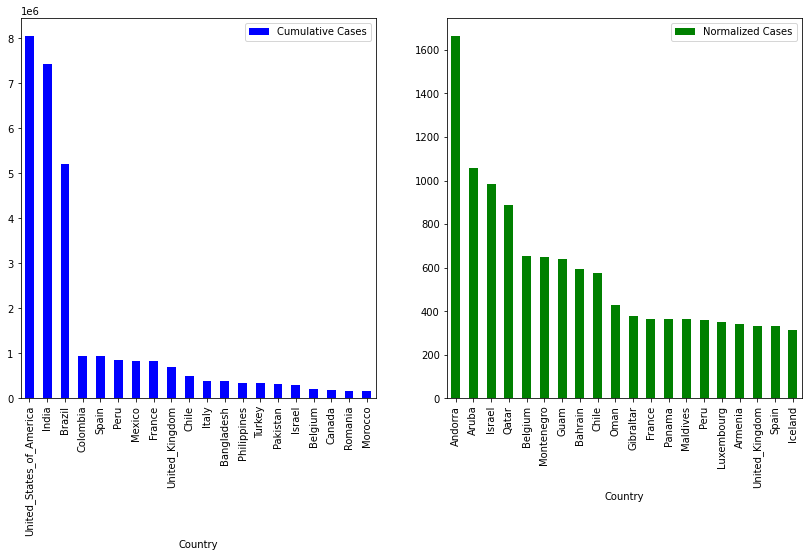

In [6]:
# Get the countries of the sorted dataset.
countries = sorted_dataset["countriesAndTerritories"].unique()

# Get the highest cumulative cases and normalized cumulative cases of each country.
highestincidences = []
highestcases = []
for i in countries:
    highestincidences.append(max(sorted_dataset[sorted_dataset["countriesAndTerritories"] == i]["Cumulative_number_for_14_days_of_COVID-19_cases_per_100000"]))
    highestcases.append(max(sorted_dataset[sorted_dataset["countriesAndTerritories"] == i]["CumulativeCases"]))

# Make list of tuples with each country and its value and sort them decreasingly.
incidences = list(zip(countries, highestincidences))
cases = list(zip(countries, highestcases))
incidences = sorted(incidences,key=lambda x: x[1], reverse=True)
cases = sorted(cases,key=lambda x: x[1], reverse=True)

# Make bar plot for the highest cases and highest incidences.
df1 = pd.DataFrame(cases[0:20], columns = ['Country', 'Cumulative Cases'])
df2 = pd.DataFrame(incidences[0:20], columns = ['Country', 'Normalized Cases'])

fig, ax =plt.subplots(1,2, figsize = (14,7))
df1.plot(kind='bar', x='Country', color = "blue", ax = ax[0])
df2.plot(kind='bar', x='Country', color = "green",ax = ax[1])


The plot below shows the importace of using normalized data instead of raw data, otherwise the cumulative cases of countries with bigger populations would be higher without representing the real incidence of covid.

The cell below:
- subsets the sorted_dataset with the 20 countries that had the highest normalized cumulative cases.
- the output is a df named "incidence_dataset"

In [7]:
# Subset the dataset by the 20 countries with highes normalized covid cumulative cases.
incidenceFilter = ["Andorra", "Aruba", "Israel", "Qatar", "Belgium", "Montenegro", "Guam", "Bahrain", "Chile", "Oman", "Gibraltar", "France", "Panama", "Maldives", "Peru", "Luxembourg", "Armenia", "United_Kingdom", "Spain", "Iceland"]
incidence_dataset = sorted_dataset[sorted_dataset["countriesAndTerritories"].isin(incidenceFilter)]

The following plot is made of three subplots that contain the following information respectively:
- The normalized cumulative cases for the 20 countries with highest covid incidence for each day.
- The normalized cumulative deaths for the 20 countries with highest covid incidence for each day.
- The relationship between the cumulative cases and the cumulative deaths .

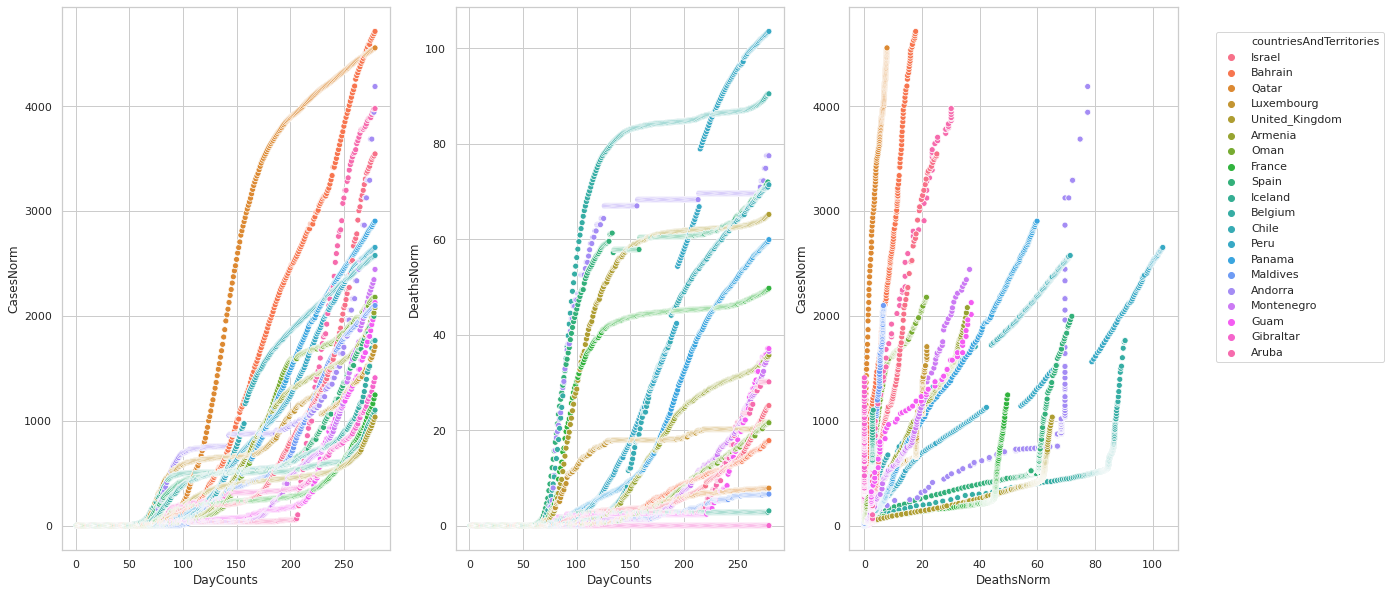

In [8]:
# Plot the cases 
sns.set(style = "whitegrid")
sns.set_palette("tab10")
fig, ax =plt.subplots(1,3, figsize = (20, 10))

plt1 = sns.scatterplot(x = "DayCounts", y = "CasesNorm", hue = "countriesAndTerritories",
                       data = incidence_dataset, legend = False, ax = ax[0])
plt2 = sns.scatterplot(x = "DayCounts", y = "DeathsNorm", hue = "countriesAndTerritories",
                     data = incidence_dataset, legend = False, ax = ax[1])
plt3 = sns.scatterplot(x = "DeathsNorm", y = "CasesNorm", hue = "countriesAndTerritories",
                     data = incidence_dataset, ax = ax[2])
plt3.legend(loc='center left', bbox_to_anchor=(1.1, 0.65), ncol = 1)

The following plot shows how the cases affect countries belonging to different income groups for each month.

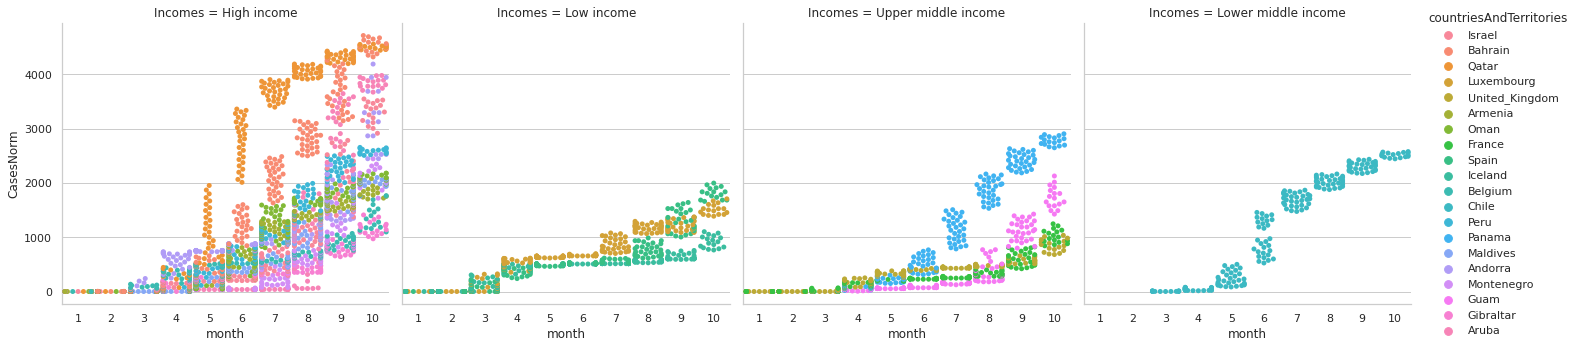

In [9]:
sns.catplot(data = incidence_dataset, kind = "swarm", x = "month", y = "CasesNorm",
            hue = "countriesAndTerritories", col = "Incomes",)

Out of personal preference, as I am a Spanish citizen living in the Republic of Ireland, and I have relatives living in the UK and Italy, I am interested on seeing how the covid pandemic has affected this particular countries.

Thus, the following cells subsets the "sorted_dataset" extracting the information of Spain, Italy, Ireland and the UK, and plots the normalized cases per month alonside the normalized deaths per month in order to compare them.

In [10]:
myFilter = ["United_Kingdom", "Italy", "Ireland", "Spain"]
my_data = sorted_dataset[sorted_dataset["countriesAndTerritories"].isin(myFilter)]

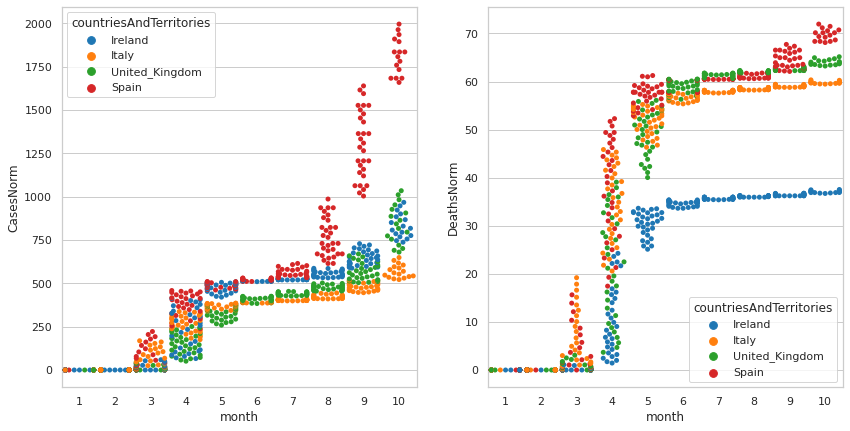

In [11]:
fig, ax =plt.subplots(1,2, figsize = (14,7))
sns.swarmplot(x="month", y="CasesNorm", hue="countriesAndTerritories", data=my_data, ax=ax[0])
sns.swarmplot(x="month", y="DeathsNorm", hue="countriesAndTerritories", data=my_data, ax=ax[1])